<a href="https://colab.research.google.com/github/altn714/ESAA/blob/main/%ED%94%8C%EC%A0%9D3_%EC%A0%84%EC%B2%98%EB%A6%AC%EC%B7%A8%ED%95%A9%EC%A4%91_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**미니 프로젝트 : 영화 관객수 예측 경진대회**
- 관련사이트 : https://dacon.io/competitions/open/235536/overview/description
- 과제 : 회귀 모델들 중 하나 이상을 해당 데이터에 적합.
- 조건 : 하이퍼 파라미터 튜닝 포함


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
#한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font',family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (6,367 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# 01 데이터 불러오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#데이터 불러오기
train = pd.read_csv("/content/movies_train.csv")
test = pd.read_csv('/content/movies_test.csv')
submission = pd.read_csv('/content/submission.csv')
#train = pd.read_csv("/content/drive/MyDrive/readcsv/영화 관객수/movies_train.csv")
#test = pd.read_csv('/content/drive/MyDrive/readcsv/영화 관객수/movies_test.csv')
#submission = pd.read_csv('/content/drive/MyDrive/readcsv/영화 관객수/submission.csv')

In [6]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


# 02 EDA 및 전처리

In [8]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [9]:
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

## 1. 영화제목 (title)

In [10]:
#title 오브젝트라서 모델 안돌아가서 뺌
train=train.drop(columns = 'title',axis=1)

## 2. 배급사 (distributor)


In [11]:
#distributor 열에서 (주) -> 주를 삭제,()만 남음 
train['distributor'] = train.distributor.str.replace("(주)", '') 
test['distributor'] = test.distributor.str.replace("(주)", '')

In [12]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [13]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

#distributor 종류 너무 많아서 get_dis 함수로 이름 통일된 것 확인
find = train[train['distributor'].str.contains('CGV')]
print(find)

Empty DataFrame
Columns: [distributor, genre, release_time, time, screening_rat, director, dir_prev_bfnum, dir_prev_num, num_staff, num_actor, box_off_num]
Index: []


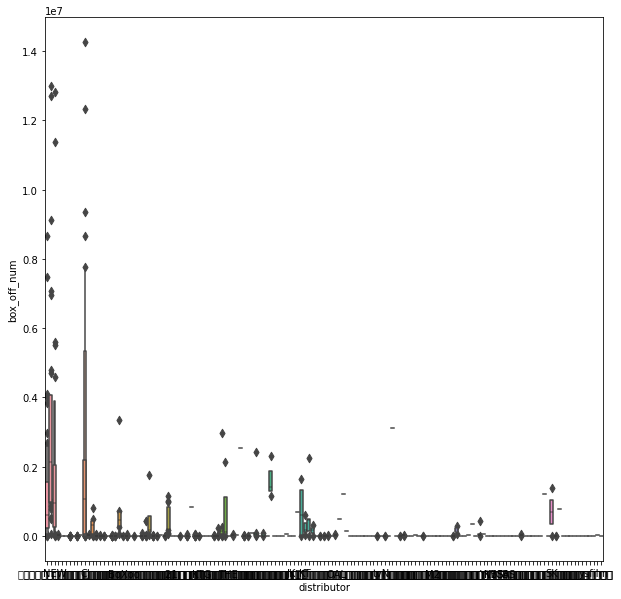

In [14]:
#배급사 별 관객수의 박스플랏 -> 이상치 존재 -> 중앙값으로 처리
plt.rcParams['figure.figsize'] = [10,10] 
sns.boxenplot(x='distributor', y='box_off_num', data=train)

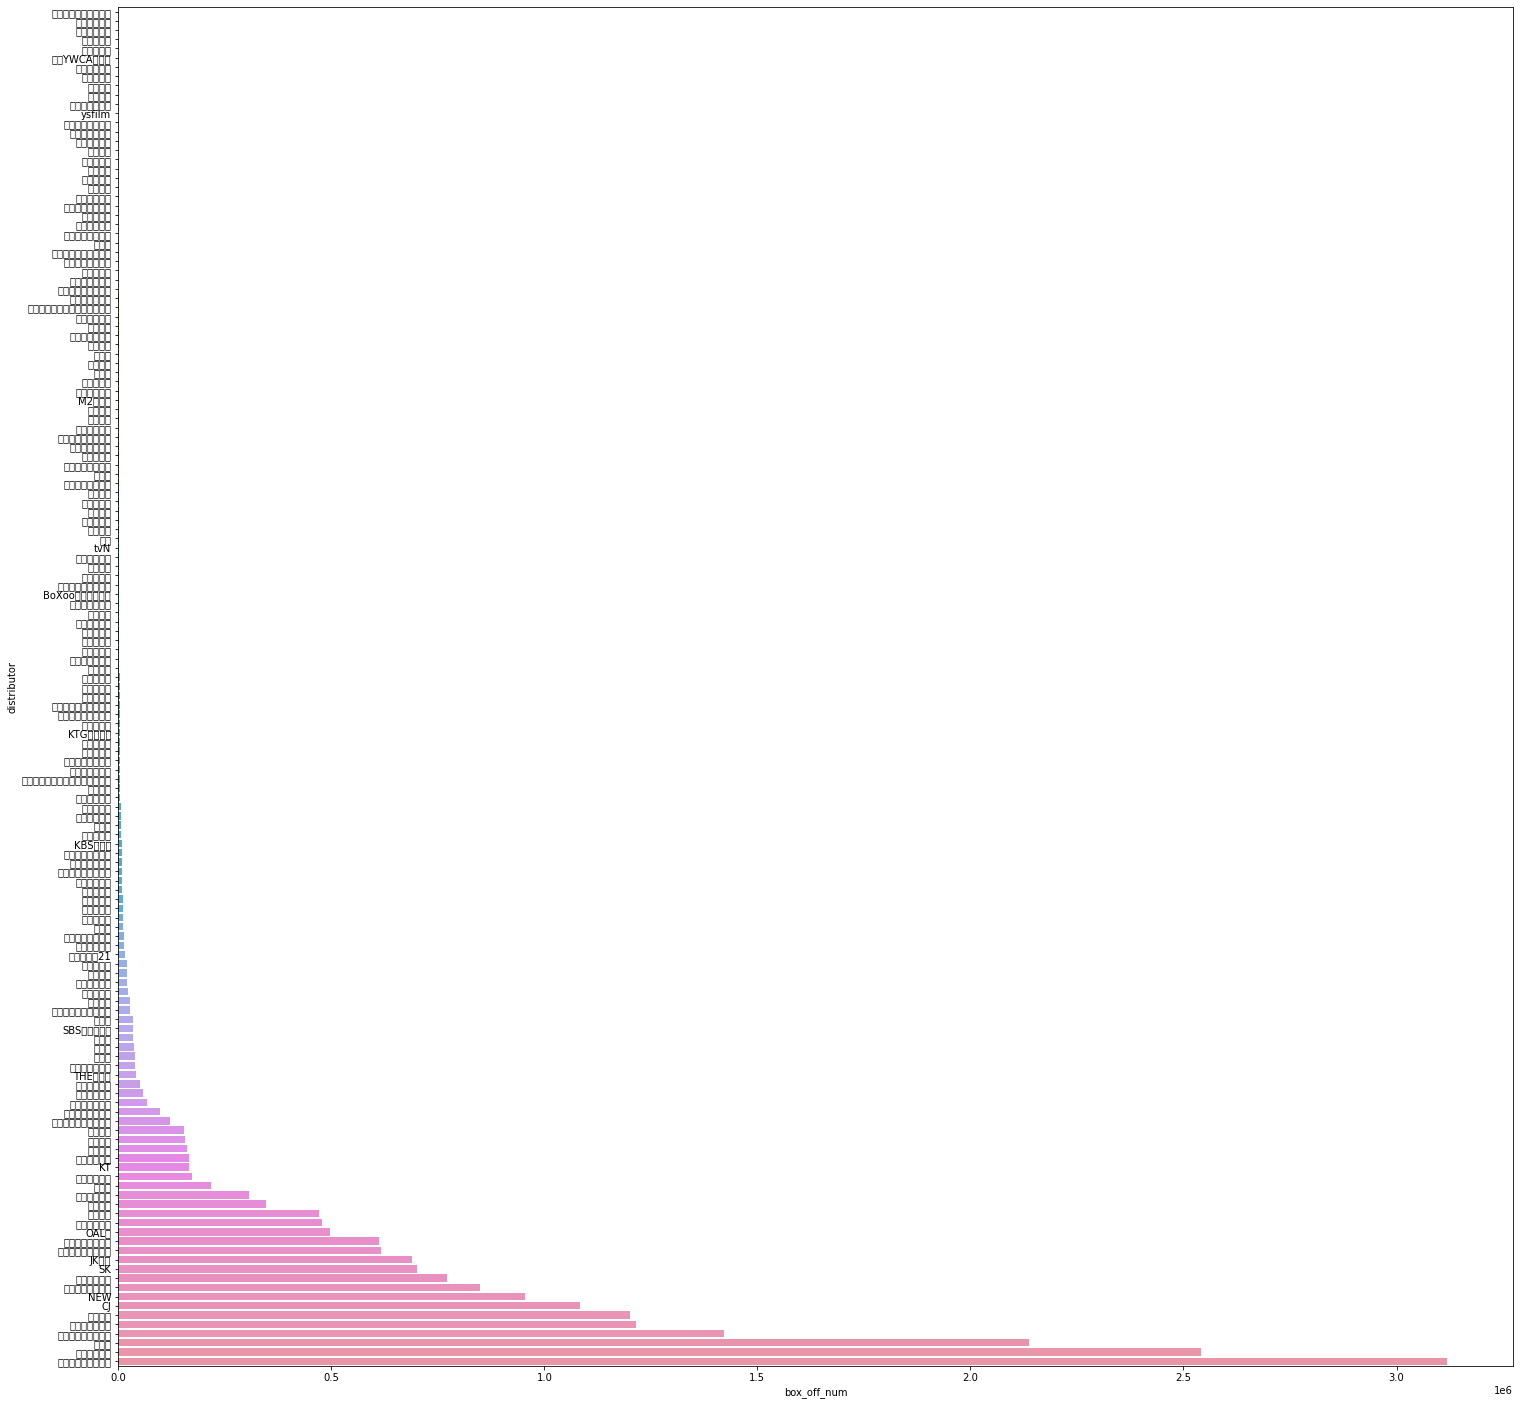

In [15]:
#배급사별 관객수 중앙값으로 처리 *로그변환 X
df1_1=pd.DataFrame(train.groupby('distributor').box_off_num.median().sort_values(ascending=True))
df1_1=df1_1.reset_index()
plt.rcParams['figure.figsize'] = [25,25] 
ax = plt.subplots()
ax = sns.barplot(x='box_off_num', y='distributor',data = df1_1)
#skewed 확인

In [16]:
df1_1 = df1_1.reset_index()
df1_1['dist_rank']=df1_1['index']+1
df1_1 = df1_1.drop('index', axis = 1)
df1_1 = df1_1.drop('box_off_num', axis = 1)

In [17]:
df1_1_OUTER_JOIN = pd.merge(train,df1_1, left_on='distributor', right_on='distributor', how='outer')
train = pd.DataFrame(df1_1_OUTER_JOIN)
train

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,134
1,롯데엔터테인먼트,코미디,2012-10-25,113,15세 관람가,육상효,837969.0,2,262,4,233211,134
2,롯데엔터테인먼트,드라마,2014-02-13,108,청소년 관람불가,권칠인,75740.0,1,288,3,781516,134
3,롯데엔터테인먼트,멜로/로맨스,2013-04-04,87,청소년 관람불가,민규동,4598985.0,1,182,3,38809,134
4,롯데엔터테인먼트,느와르,2013-11-14,124,청소년 관람불가,곽경택,372863.0,2,319,3,2971475,134
...,...,...,...,...,...,...,...,...,...,...,...,...
595,영화사,드라마,2012-12-06,100,15세 관람가,김성훈,86837.0,2,10,3,7173,89
596,크리에이티브컴즈,드라마,2012-09-13,61,15세 관람가,전화성,424.0,2,6,8,188,13
597,ysfilm,드라마,2010-07-01,78,12세 관람가,조연수,NaN,0,17,7,172,12
598,이달투,애니메이션,2014-08-21,90,전체 관람가,안재훈,53235.0,1,167,7,35567,110


In [18]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [19]:
#test data에는 box_off_num이 없음 -> 그냥 train data의 dist_rank를 test data에 새로운 열 dist_rank 추가함.
join=pd.merge(test,df1_1,left_on='distributor', right_on='distributor', how='left') #df1_1에 없는 값을 다 NaN처리함.
test = pd.DataFrame(join)
test

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dist_rank
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,132.0
1,아빠가 여자를 좋아해,쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,145.0
2,하모니,CJ,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,141.0
3,의형제,쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,145.0
4,평행 이론,CJ,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4,112.0
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2,69.0
240,어떤살인,컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4,NaN
241,말하지 못한 비밀,마운틴픽처스,드라마,2015-10-22,102,청소년 관람불가,송동윤,5.069900e+04,1,68,7,46.0


In [20]:
#train 데이터 기준으로 만들어진 rank라서 train에 없는 test의 distributor는 NaN값으로 뜸, 여기서 이것을 순위가 제일 안좋은 0으로 처리할지?
test['dist_rank'] = test['dist_rank'].fillna(0)
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dist_rank           0
dtype: int64

## 3. 장르 (genre)

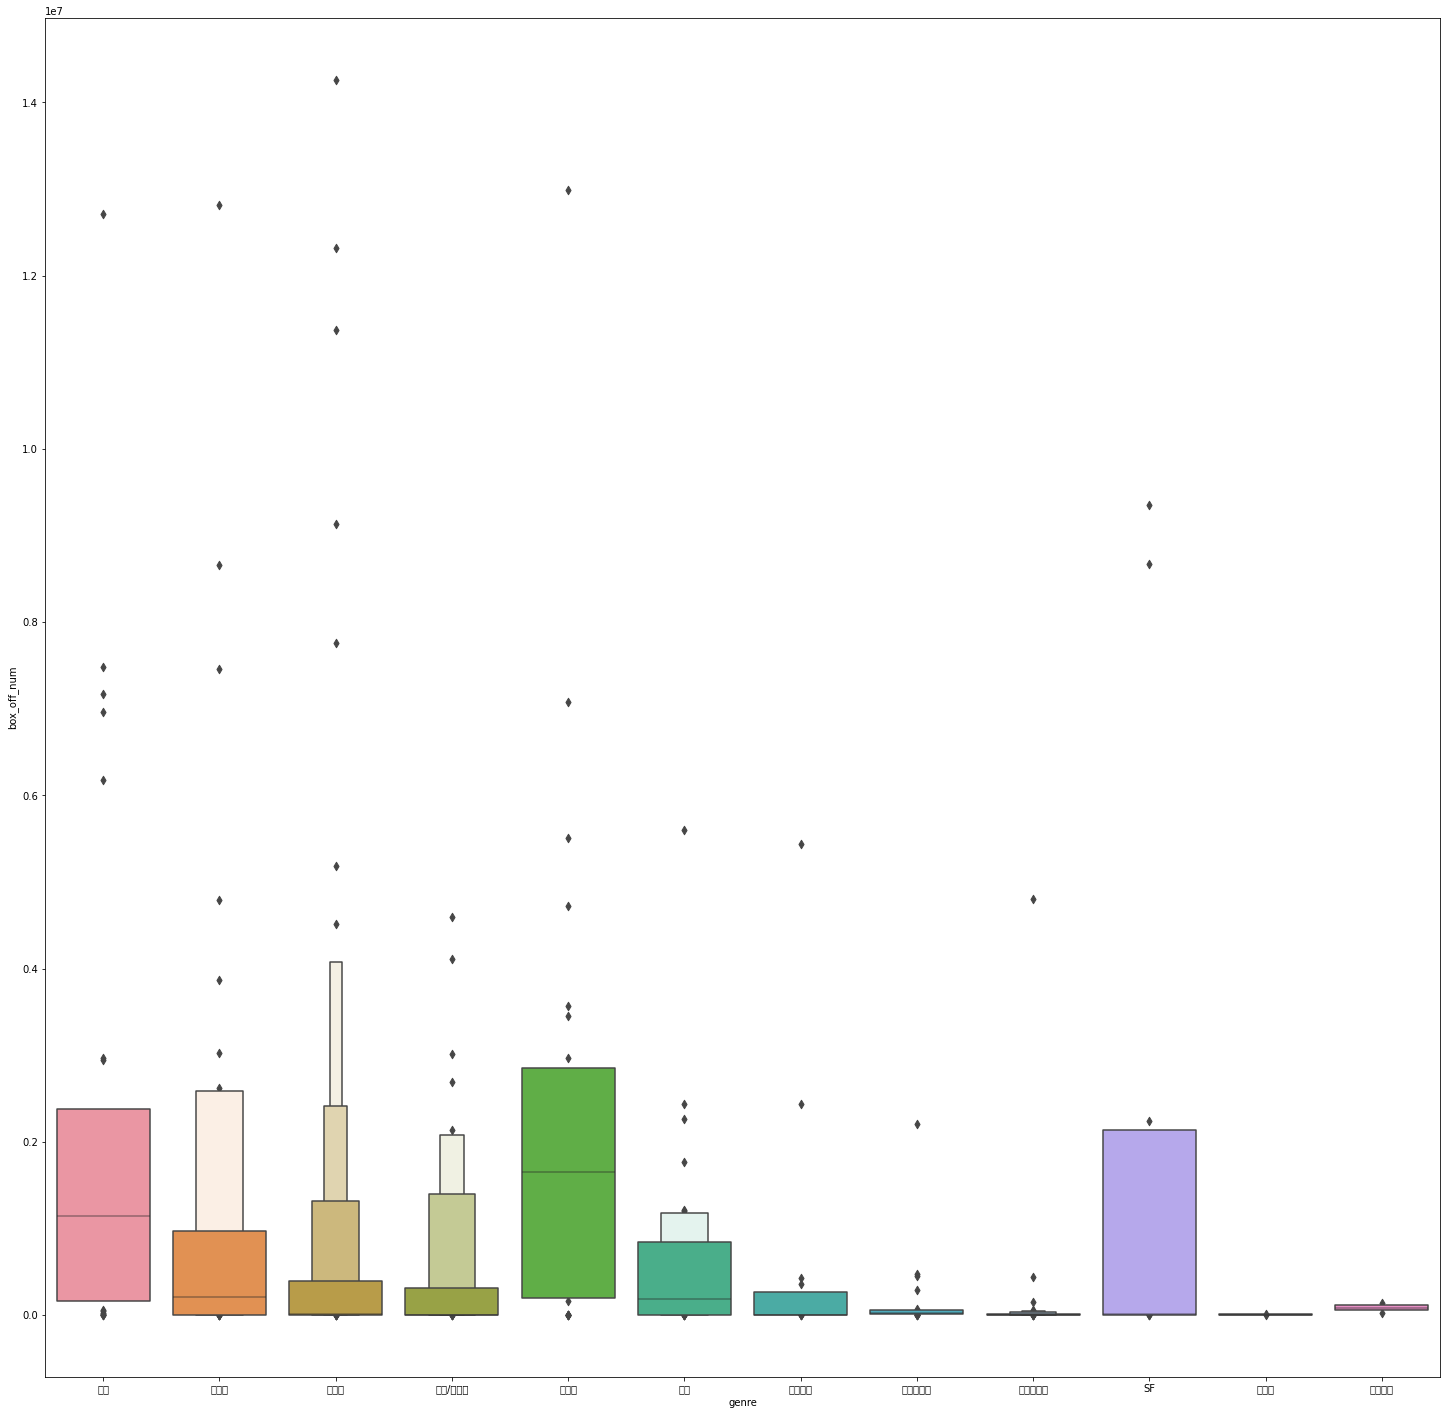

In [21]:
#장르 별 관객 수의 박스플랏
sns.boxenplot(x='genre', y='box_off_num', data=train)

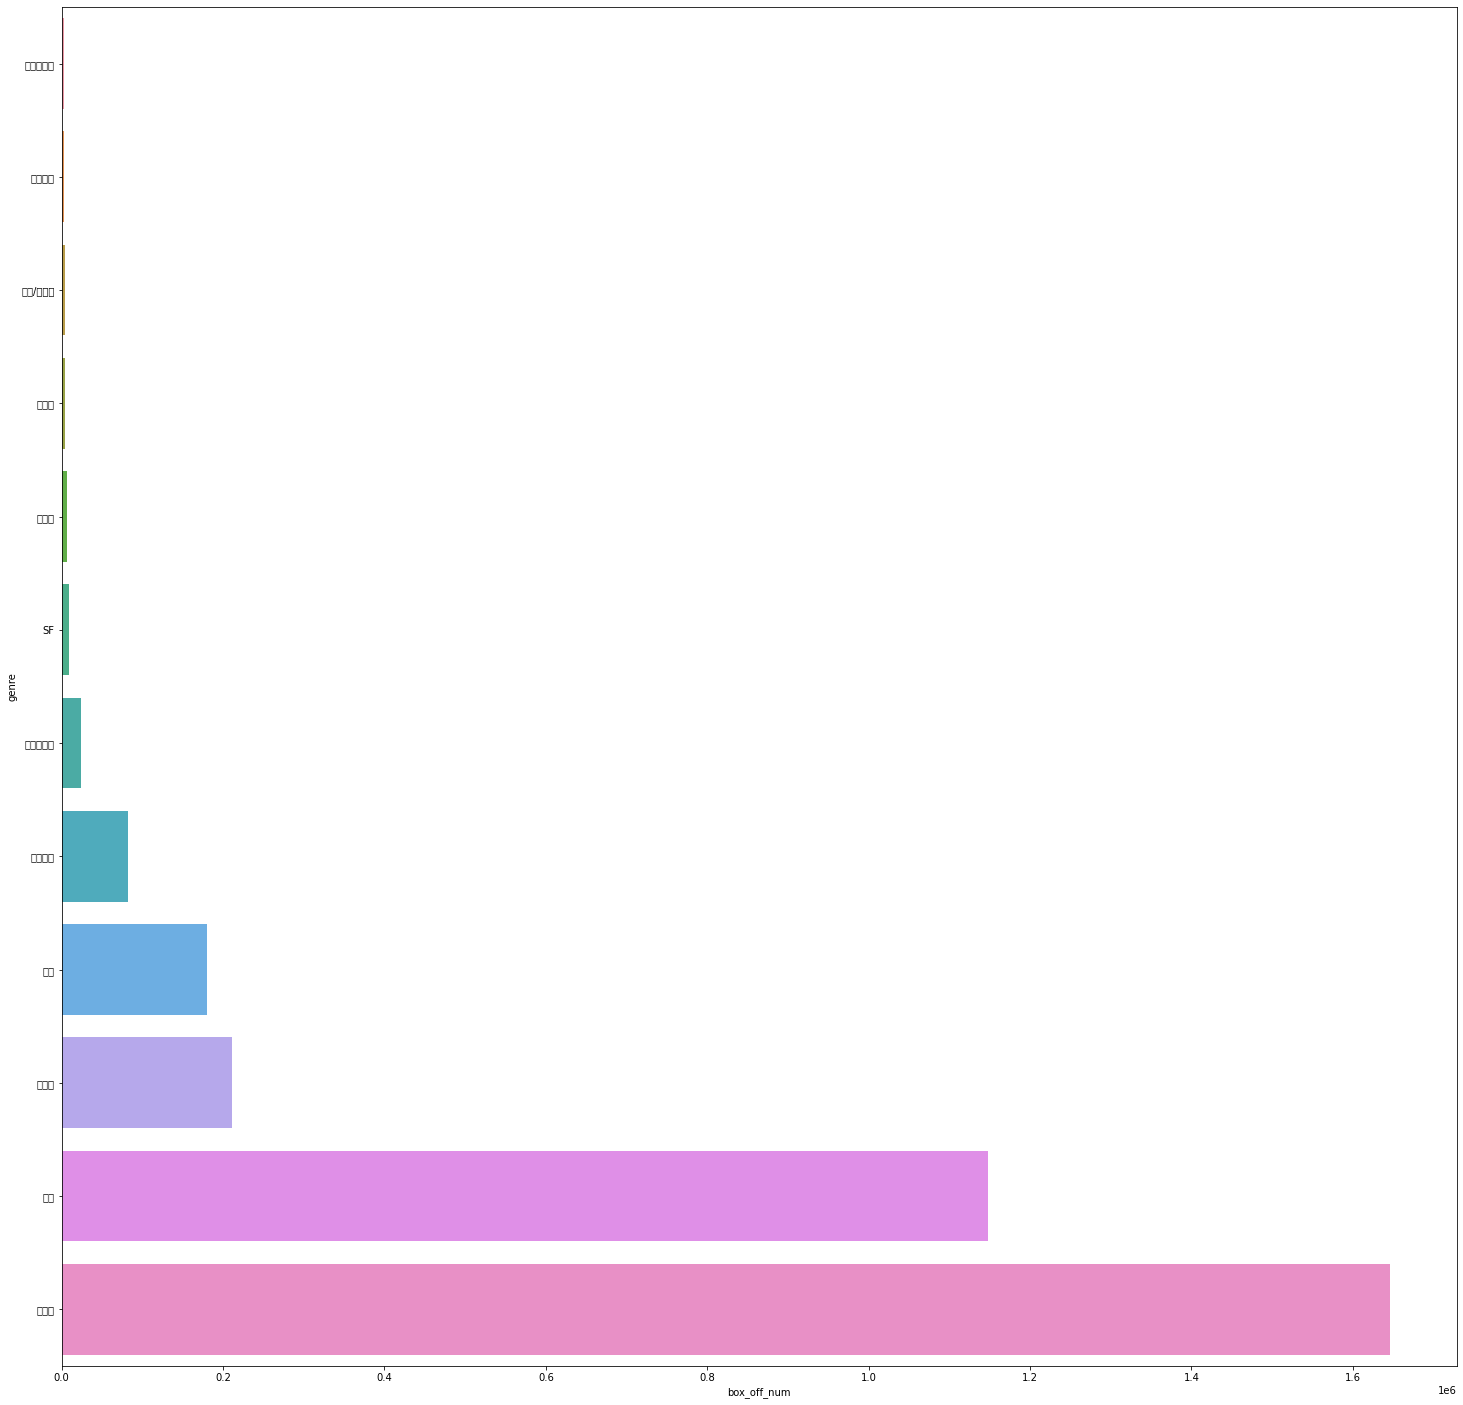

In [22]:
#장르별 관객수 중앙값으로 처리 *로그변환 X
df2_1=pd.DataFrame(train.groupby('genre').box_off_num.median().sort_values(ascending=True))
df2_1=df2_1.reset_index()
plt.rcParams['figure.figsize'] = [25,25] 
ax = plt.subplots()
ax = sns.barplot(x='box_off_num', y='genre',data = df2_1)
#skewed 확인

In [23]:
df2_1 = df2_1.reset_index()
df2_1['genre_rank']=df2_1['index']+1
df2_1 = df2_1.drop('index', axis = 1)
df2_1 = df2_1.drop('box_off_num', axis = 1)

In [24]:
df2_1_OUTER_JOIN = pd.merge(train,df2_1, left_on='genre', right_on='genre', how='outer')
train = pd.DataFrame(df2_1_OUTER_JOIN)
train

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank,genre_rank
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,134,11
1,롯데엔터테인먼트,액션,2011-11-24,111,15세 관람가,황병국,NaN,0,253,6,1118258,134,11
2,롯데엔터테인먼트,액션,2011-08-10,122,15세 관람가,김한민,2.079989e+06,1,687,4,7482180,134,11
3,롯데엔터테인먼트,액션,2015-09-24,112,12세 관람가,천성일,4.385472e+06,2,388,2,609063,134,11
4,롯데엔터테인먼트,액션,2015-08-13,121,15세 관람가,박흥식,1.209303e+05,3,439,3,431310,134,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,영화사조제,뮤지컬,2011-06-09,100,12세 관람가,신춘수,NaN,0,4,4,3089,54,4
596,패뷸러스,뮤지컬,2015-10-22,80,전체 관람가,정성복,NaN,0,0,0,862,37,4
597,SK,뮤지컬,2011-11-17,133,전체 관람가,정성복,NaN,0,4,4,16323,137,4
598,팝파트너스,서스펜스,2013-09-25,107,청소년 관람불가,한종훈,5.342325e+05,2,15,4,23052,107,8


In [25]:
#test data에는 box_off_num이 없음 -> 그냥 train data의 genre_rank를 test data에 새로운 열 dist_rank 추가함.
join2=pd.merge(test,df2_1,left_on='genre', right_on='genre', how='left')
test = pd.DataFrame(join2)
test

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dist_rank,genre_rank
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,132.0,12
1,아빠가 여자를 좋아해,쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,145.0,3
2,하모니,CJ,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,141.0,5
3,의형제,쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,145.0,11
4,평행 이론,CJ,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,141.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4,112.0,5
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2,69.0,1
240,어떤살인,컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4,0.0,12
241,말하지 못한 비밀,마운틴픽처스,드라마,2015-10-22,102,청소년 관람불가,송동윤,5.069900e+04,1,68,7,46.0,5


In [26]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dist_rank           0
genre_rank          0
dtype: int64

**2번 & 3번 사용된 변수 삭제**
(distributor,genre 삭제)

In [27]:
train.drop(['distributor','genre'], axis=1, inplace=True) 
#train.drop(['distributor','genre','box_off_num'], axis=1, inplace=True) #box_off_num 삭제할지 말지,,
test.drop(['distributor','genre'], axis=1, inplace=True)

In [28]:
train.columns

Index(['release_time', 'time', 'screening_rat', 'director', 'dir_prev_bfnum',
       'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'dist_rank',
       'genre_rank'],
      dtype='object')

In [29]:
test.columns

Index(['title', 'release_time', 'time', 'screening_rat', 'director',
       'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'dist_rank',
       'genre_rank'],
      dtype='object')

## 4. 개봉일 (release_time)

### * 데이트타임 형식으로 바꾸고 연,월,일 나누기

In [30]:
#목차에 5. 상영시간(time)에서 
#train['time_log'] = np.log1p(train.time)
#test['time_log'] = np.log1p(test.time)
#train['box_off_num_log'] = np.log1p(train.box_off_num)
#test['box_off_num_log'] = np.log1p(test.box_off_num)
#이거를 

train['time_log'] = np.log1p(train.time)
test['time_log'] = np.log1p(test.time)
train.drop(['time'], axis=1, inplace=True)
test.drop(['time'], axis=1, inplace=True)
train['box_off_num_log'] = np.log1p(train.box_off_num)
#test['box_off_num_log'] = np.log1p(test.box_off_num)

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   release_time     600 non-null    object 
 1   screening_rat    600 non-null    object 
 2   director         600 non-null    object 
 3   dir_prev_bfnum   270 non-null    float64
 4   dir_prev_num     600 non-null    int64  
 5   num_staff        600 non-null    int64  
 6   num_actor        600 non-null    int64  
 7   box_off_num      600 non-null    int64  
 8   dist_rank        600 non-null    int64  
 9   genre_rank       600 non-null    int64  
 10  time_log         600 non-null    float64
 11  box_off_num_log  600 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 60.9+ KB


In [32]:
sns.pairplot(train[['release_year', 'release_month', 'release_quarter', 'release_day', 'box_off_num']])
plt.show()

KeyError: ignored

### * 인코딩 및 로그변환
* 카테고리형변수이므로 인코딩
* Label encoding은 가중치 부여, One-Hot encoding은 너무 많은 변수가 만들어진다는 단점이 있다.
* Binary encoding은 이진법 분류 기법으로, 가중치 부여하지 않고 적은 양의 변수만 만들어지는 장점이 있어, 이 기법을 적용한다.

In [33]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 773 kB/s 


In [34]:
import category_encoders as ce

ec_y = ce.BinaryEncoder(cols=['release_year'])
df_y = ec_y.fit_transform(train['release_year'])
df_y_te = ec_y.fit_transform(test['release_year'])

ec_m = ce.BinaryEncoder(cols=['release_month'])
df_m = ec_m.fit_transform(train['release_month'])
df_m_te = ec_m.fit_transform(test['release_month'])

ec_q = ce.BinaryEncoder(cols=['release_quarter'])
df_q = ec_q.fit_transform(train['release_quarter'])
df_q_te = ec_q.fit_transform(test['release_quarter'])

ec_d = ce.BinaryEncoder(cols=['release_day'])
df_d = ec_d.fit_transform(train['release_day'])
df_d_te = ec_d.fit_transform(test['release_day'])

train = pd.concat([train, df_y, df_m, df_q, df_d], axis=1)
train.drop(['release_year', 'release_month', 'release_quarter', 'release_day'], axis=1, inplace=True)
train.head()

test = pd.concat([test, df_y_te, df_m_te, df_q_te, df_d_te], axis=1)
test.drop(['release_year', 'release_month', 'release_quarter', 'release_day'], axis=1, inplace=True)

KeyError: ignored

## 5. 상영시간 (time)

### * 데이트타임 형식으로 바꾸면 연속형변수로 활용할 수 없으므로 안한다.

In [ ]:
#train['time'] = train.time.apply(pd.to_datetime)

### * 로그변환
* time은 연속형 변수이고 불균형한 분포이므로, 로그변환하기

In [37]:
#위에서 title 지움
#sns.pairplot(train[['time', 'box_off_num']])
#plt.show()

In [38]:
train['time_log'] = np.log1p(train.time)
test['time_log'] = np.log1p(test.time)
train['box_off_num_log'] = np.log1p(train.box_off_num)
#test['box_off_num_log'] = np.log1p(test.box_off_num)

AttributeError: ignored

### * 로그변환 후 관계 보기
* 상관관계가 명확히 드러난다.

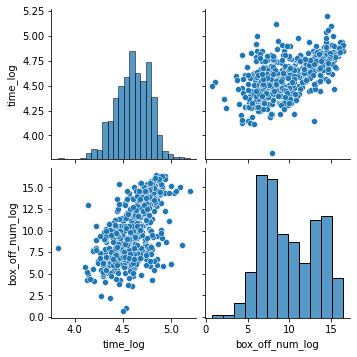

In [39]:
sns.pairplot(train[['time_log', 'box_off_num_log']])
plt.show()

## 6. 감독이름 (director)

### * 랭크 인코딩
*   감독별 관객 수 분포 조사 -> 왜곡 정도 완화 -> 중앙값으로 rank 매기기
*   감독이 낸 영화 수를 고려하여 감독별 관객 수 평균을 이용함

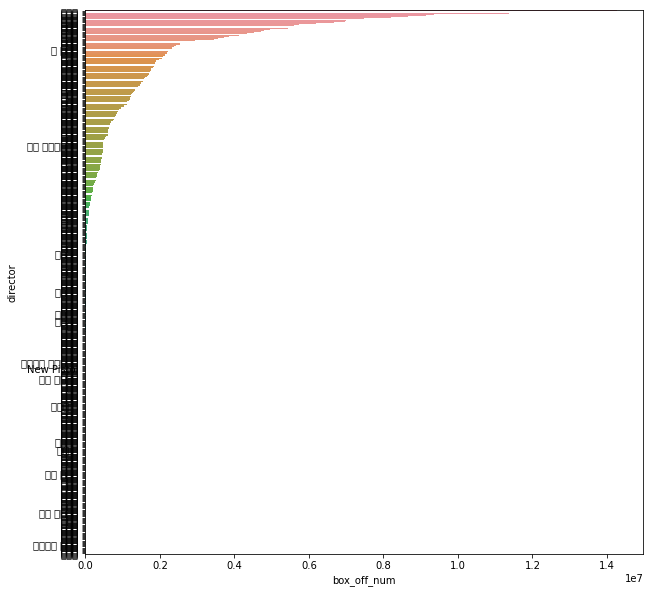

In [40]:
director_num = train.groupby('director')['box_off_num'].mean().sort_values(ascending=False) #원래 sum이었는데 감독별 영화 수 고려하여 mean으로 수정
df6 = pd.DataFrame(director_num)
df6["director"]= df6.index #director 열 생성
plt.rcParams['figure.figsize'] = [10,10] 
ax = plt.subplots()
ax = sns.barplot(x='box_off_num', y='director',data = df6)

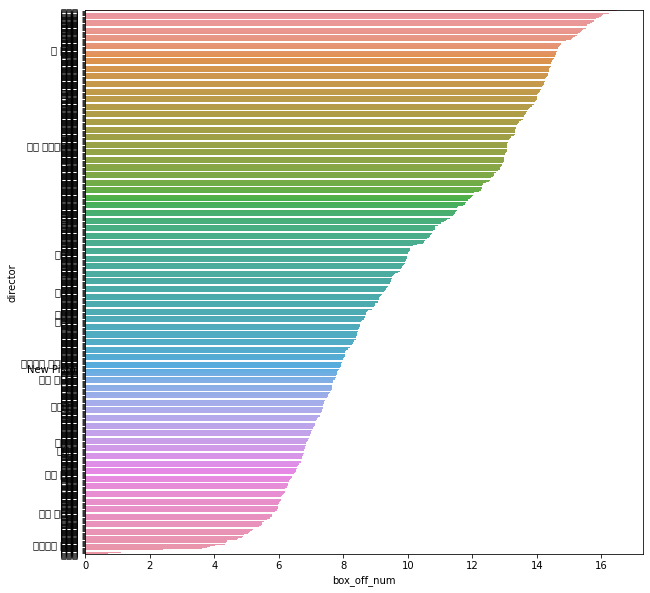

In [41]:
#위의 그래프가 왜곡되어있으므로 log1p 변환을 통해 왜곡 정도 향상
director_num = train.groupby('director')['box_off_num'].mean().sort_values(ascending=False)
df6 = pd.DataFrame(director_num)
df6["director"]= df6.index #director 열 생성
plt.rcParams['figure.figsize'] = [10,10] 
df6["box_off_num"]=np.log1p(df6["box_off_num"])
ax = plt.subplots()
ax = sns.barplot(x='box_off_num', y='director',data = df6)

In [42]:
df6.drop(['director'], axis=1, inplace=True)
tr_dr_rank = df6.groupby('director').box_off_num.median().reset_index(name = 'dr_rank').sort_values(by = 'dr_rank')
tr_dr_rank

,director,dr_rank
125,노성수,0.693147
85,김정호,1.098612
10,고구마,2.197225
289,이세일,2.397895
411,진광교,3.610918
...,...,...
448,한재림,16.027712
201,봉준호,16.050925
241,양우석,16.246918
416,최동훈,16.368485


In [43]:
tr_dr_rank['dr_rank2'] = tr_dr_rank['dr_rank'].rank(method='dense', ascending=True)
#tr_dr_rank['dr_rank2'] = [i/5 + 1 for i in range(tr_dr_rank.shape[0])] #i+1로 하면 1~472로 너무 커지는 것 같아서 수정했는데, 다른 스케일링 이용할지?
#로그 스케일링 한 거니까 랭크 매기기 전 값으로 진행하면..? 일단 매기기 전 값이 dr_rank, 랭크가 dr_rank2

In [44]:
tr_dr_rank

,director,dr_rank,dr_rank2
125,노성수,0.693147,1.0
85,김정호,1.098612,2.0
10,고구마,2.197225,3.0
289,이세일,2.397895,4.0
411,진광교,3.610918,5.0
...,...,...,...
448,한재림,16.027712,464.0
201,봉준호,16.050925,465.0
241,양우석,16.246918,466.0
416,최동훈,16.368485,467.0


In [45]:
#dr_rank, dr_rank2 원래 데이터에 추가
train = pd.merge(train, tr_dr_rank, how = 'left')
test = pd.merge(test, tr_dr_rank, how = 'left')

In [46]:
train.head()

,release_time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,dr_rank,dr_rank2
0,2012-11-22,청소년 관람불가,조병옥,NaN,0,91,2,23398,134,11,4.574711,10.060449,10.060449,261.0
1,2011-11-24,15세 관람가,황병국,NaN,0,253,6,1118258,134,11,4.718499,13.927284,13.927284,388.0
2,2011-08-10,15세 관람가,김한민,2.079989e+06,1,687,4,7482180,134,11,4.812184,15.828035,15.828035,461.0
3,2015-09-24,12세 관람가,천성일,4.385472e+06,2,388,2,609063,134,11,4.727388,13.319679,13.319679,363.0
4,2015-08-13,15세 관람가,박흥식,1.209303e+05,3,439,3,431310,134,11,4.804021,12.974585,12.974585,339.0


## 7. 감독의 전작영화 평균 관객 수 (dir_prev_bfnum)

### * 결측치 처리

In [47]:
train['dir_prev_bfnum'].isnull().sum()

330

In [48]:
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)
train['dir_prev_bfnum'].isnull().sum()

0

### * 랭크 인코딩
* 위와 같은 방법

director_num = train.groupby('director')['dir_prev_bfnum'].sum().sort_values(ascending=False)
df7 = pd.DataFrame(director_num)
df7["director"]= df7.index #director 열 생성
plt.rcParams['figure.figsize'] = [10,10] 
ax = plt.subplots()
ax = sns.barplot(x='dir_prev_bfnum', y='director',data = df7)

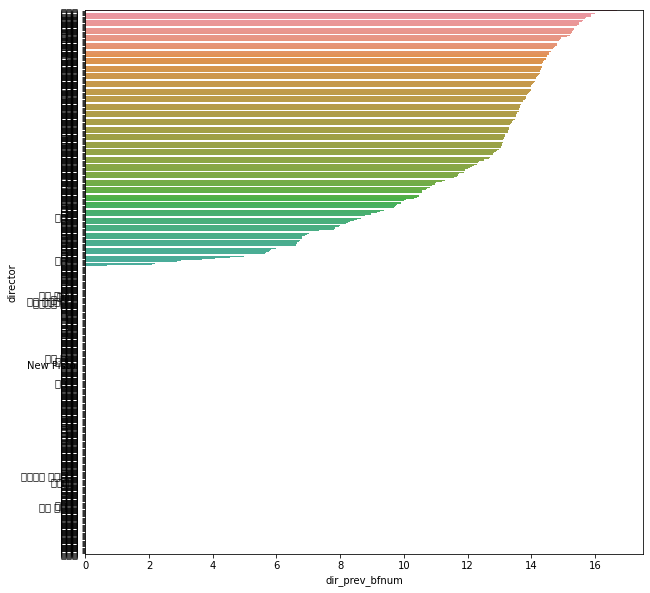

In [49]:
#위의 그래프가 왜곡되어있으므로 log1p 변환을 통해 왜곡 정도 향상
director_num = train.groupby('director')['dir_prev_bfnum'].sum().sort_values(ascending=False)
df7 = pd.DataFrame(director_num)
df7["director"]= df7.index #director 열 생성
plt.rcParams['figure.figsize'] = [10,10] 
df7['dir_prev_bfnum']=np.log1p(df7['dir_prev_bfnum']) 
ax = plt.subplots()
ax = sns.barplot(x='dir_prev_bfnum', y='director',data = df7)

In [50]:
df7.drop(['director'], axis=1, inplace=True)
tr_drbf_rank = df7.groupby('director').dir_prev_bfnum.median().reset_index(name = 'drbf_rank').sort_values(by = 'drbf_rank')
tr_drbf_rank

,director,drbf_rank
0,New Pistol,0.000000
277,이대희,0.000000
275,이길보라,0.000000
273,이규만,0.000000
272,이광호,0.000000
...,...,...
62,김상진,15.871628
232,심형래,15.876721
53,김민석,15.990449
5,강형철,16.591959


In [51]:
tr_drbf_rank['drbf_rank2'] = tr_drbf_rank['drbf_rank'].rank(method='dense', ascending=True)
tr_drbf_rank

,director,drbf_rank,drbf_rank2
0,New Pistol,0.000000,1.0
277,이대희,0.000000,1.0
275,이길보라,0.000000,1.0
273,이규만,0.000000,1.0
272,이광호,0.000000,1.0
...,...,...,...
62,김상진,15.871628,213.0
232,심형래,15.876721,214.0
53,김민석,15.990449,215.0
5,강형철,16.591959,216.0


In [52]:
#drbf_rank, drbf_rank2 원래 데이터에 추가
train = pd.merge(train, tr_drbf_rank, how = 'left')
test = pd.merge(test, tr_drbf_rank, how = 'left')

In [53]:
train.head()

,release_time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,dr_rank,dr_rank2,drbf_rank,drbf_rank2
0,2012-11-22,청소년 관람불가,조병옥,0.000000e+00,0,91,2,23398,134,11,4.574711,10.060449,10.060449,261.0,0.000000,1.0
1,2011-11-24,15세 관람가,황병국,0.000000e+00,0,253,6,1118258,134,11,4.718499,13.927284,13.927284,388.0,0.000000,1.0
2,2011-08-10,15세 관람가,김한민,2.079989e+06,1,687,4,7482180,134,11,4.812184,15.828035,15.828035,461.0,14.547874,181.0
3,2015-09-24,12세 관람가,천성일,4.385472e+06,2,388,2,609063,134,11,4.727388,13.319679,13.319679,363.0,15.293808,200.0
4,2015-08-13,15세 관람가,박흥식,1.209303e+05,3,439,3,431310,134,11,4.804021,12.974585,12.974585,339.0,11.702978,76.0


## 8. 감독의 전작영화 수 (dir_prev_num)

In [54]:
train['dir_prev_num'].isnull().sum()

0

### * 랭크 인코딩
* 위와 같은 방법

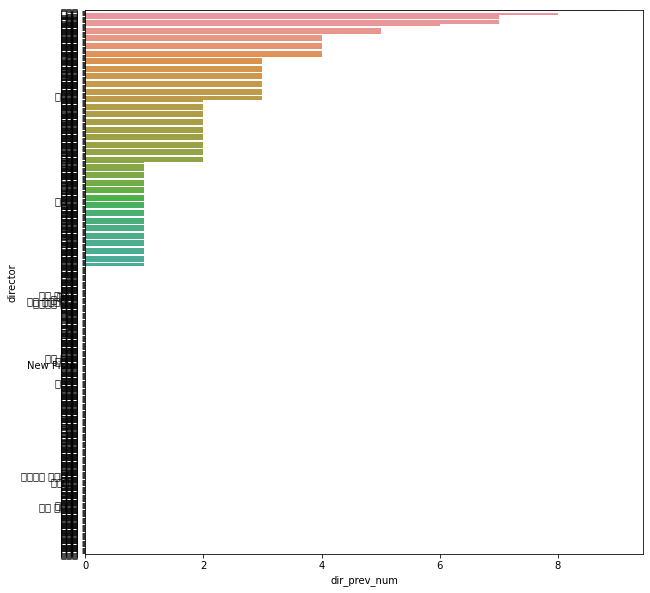

In [55]:
director_num = train.groupby('director')['dir_prev_num'].sum().sort_values(ascending=False)
df8 = pd.DataFrame(director_num)
df8["director"]= df8.index #director 열 생성
plt.rcParams['figure.figsize'] = [10,10] 
ax = plt.subplots()
ax = sns.barplot(x='dir_prev_num', y='director',data = df8)

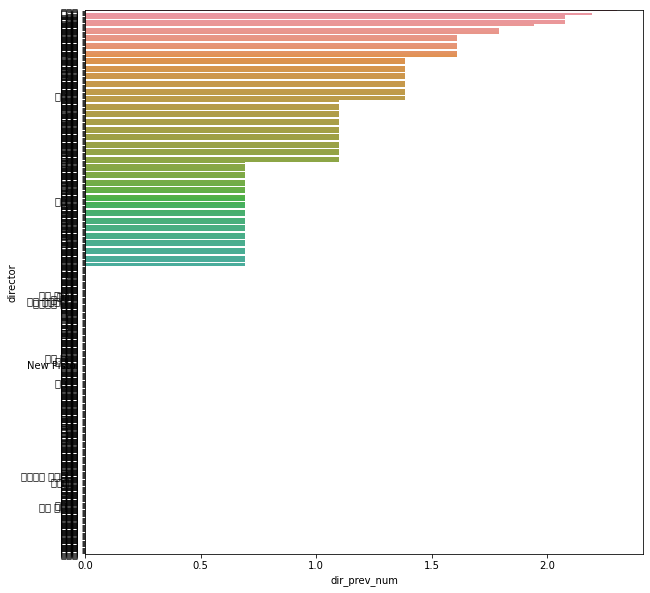

In [56]:
#위의 그래프가 왜곡되어있으므로 log1p 변환을 통해 왜곡 정도 향상
director_num = train.groupby('director')['dir_prev_num'].sum().sort_values(ascending=False)
df8 = pd.DataFrame(director_num)
df8["director"]= df8.index #director 열 생성
plt.rcParams['figure.figsize'] = [10,10] 
df8['dir_prev_num']=np.log1p(df8['dir_prev_num']) 
ax = plt.subplots()
ax = sns.barplot(x='dir_prev_num', y='director',data = df8)

In [57]:
df8.drop(['director'], axis=1, inplace=True)
tr_drp_rank = df8.groupby('director').dir_prev_num.median().reset_index(name = 'drp_rank').sort_values(by = 'drp_rank')
tr_drp_rank

,director,drp_rank
0,New Pistol,0.000000
277,이대희,0.000000
275,이길보라,0.000000
273,이규만,0.000000
272,이광호,0.000000
...,...,...
258,유하,2.079442
324,이해영,2.197225
118,김휘,2.197225
62,김상진,2.197225


In [58]:
tr_drp_rank['drp_rank2'] = tr_drp_rank['drp_rank'].rank(method='dense', ascending=True)
tr_drp_rank

,director,drp_rank,drp_rank2
0,New Pistol,0.000000,1.0
277,이대희,0.000000,1.0
275,이길보라,0.000000,1.0
273,이규만,0.000000,1.0
272,이광호,0.000000,1.0
...,...,...,...
258,유하,2.079442,8.0
324,이해영,2.197225,9.0
118,김휘,2.197225,9.0
62,김상진,2.197225,9.0


In [59]:

#drp_rank, drp_rank2 원래 데이터에 추가
train = pd.merge(train, tr_drp_rank, how = 'left')
test = pd.merge(test, tr_drp_rank, how = 'left')

In [60]:
train.head()

,release_time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,dr_rank,dr_rank2,drbf_rank,drbf_rank2,drp_rank,drp_rank2
0,2012-11-22,청소년 관람불가,조병옥,0.000000e+00,0,91,2,23398,134,11,4.574711,10.060449,10.060449,261.0,0.000000,1.0,0.000000,1.0
1,2011-11-24,15세 관람가,황병국,0.000000e+00,0,253,6,1118258,134,11,4.718499,13.927284,13.927284,388.0,0.000000,1.0,0.000000,1.0
2,2011-08-10,15세 관람가,김한민,2.079989e+06,1,687,4,7482180,134,11,4.812184,15.828035,15.828035,461.0,14.547874,181.0,0.693147,2.0
3,2015-09-24,12세 관람가,천성일,4.385472e+06,2,388,2,609063,134,11,4.727388,13.319679,13.319679,363.0,15.293808,200.0,1.098612,3.0
4,2015-08-13,15세 관람가,박흥식,1.209303e+05,3,439,3,431310,134,11,4.804021,12.974585,12.974585,339.0,11.702978,76.0,1.386294,4.0


### * 감독 관련 변수(6,7,8번)를 결합한 전처리

In [61]:
train['dr_mean'] = (train['dr_rank']+train['drbf_rank'])/2  
#6,7번 평균낸 변수 추가
test['dr_mean'] = (test['dr_rank']+test['drbf_rank'])/2
train.head()

,release_time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,dr_rank,dr_rank2,drbf_rank,drbf_rank2,drp_rank,drp_rank2,dr_mean
0,2012-11-22,청소년 관람불가,조병옥,0.000000e+00,0,91,2,23398,134,11,4.574711,10.060449,10.060449,261.0,0.000000,1.0,0.000000,1.0,5.030224
1,2011-11-24,15세 관람가,황병국,0.000000e+00,0,253,6,1118258,134,11,4.718499,13.927284,13.927284,388.0,0.000000,1.0,0.000000,1.0,6.963642
2,2011-08-10,15세 관람가,김한민,2.079989e+06,1,687,4,7482180,134,11,4.812184,15.828035,15.828035,461.0,14.547874,181.0,0.693147,2.0,15.187954
3,2015-09-24,12세 관람가,천성일,4.385472e+06,2,388,2,609063,134,11,4.727388,13.319679,13.319679,363.0,15.293808,200.0,1.098612,3.0,14.306743
4,2015-08-13,15세 관람가,박흥식,1.209303e+05,3,439,3,431310,134,11,4.804021,12.974585,12.974585,339.0,11.702978,76.0,1.386294,4.0,12.338781


In [62]:
train['dr_mean2'] = train['dr_mean'].rank(method='dense', ascending=True) #평균값 rank 변수 추가
test['dr_mean2'] = test['dr_mean'].rank(method='dense', ascending=True)
train.head()

,release_time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,dr_rank,dr_rank2,drbf_rank,drbf_rank2,drp_rank,drp_rank2,dr_mean,dr_mean2
0,2012-11-22,청소년 관람불가,조병옥,0.000000e+00,0,91,2,23398,134,11,4.574711,10.060449,10.060449,261.0,0.000000,1.0,0.000000,1.0,5.030224,180.0
1,2011-11-24,15세 관람가,황병국,0.000000e+00,0,253,6,1118258,134,11,4.718499,13.927284,13.927284,388.0,0.000000,1.0,0.000000,1.0,6.963642,246.0
2,2011-08-10,15세 관람가,김한민,2.079989e+06,1,687,4,7482180,134,11,4.812184,15.828035,15.828035,461.0,14.547874,181.0,0.693147,2.0,15.187954,462.0
3,2015-09-24,12세 관람가,천성일,4.385472e+06,2,388,2,609063,134,11,4.727388,13.319679,13.319679,363.0,15.293808,200.0,1.098612,3.0,14.306743,433.0
4,2015-08-13,15세 관람가,박흥식,1.209303e+05,3,439,3,431310,134,11,4.804021,12.974585,12.974585,339.0,11.702978,76.0,1.386294,4.0,12.338781,367.0


In [63]:
train.drop(['director','dir_prev_bfnum','dir_prev_num'], axis=1, inplace=True) #새 변수 만드는데 사용한 변수 모두 삭제. box_off_num은 전이나 후에 타겟 처리
test.drop(['director','dir_prev_bfnum','dir_prev_num'], axis=1, inplace=True)
train.head()

,release_time,screening_rat,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,dr_rank,dr_rank2,drbf_rank,drbf_rank2,drp_rank,drp_rank2,dr_mean,dr_mean2
0,2012-11-22,청소년 관람불가,91,2,23398,134,11,4.574711,10.060449,10.060449,261.0,0.000000,1.0,0.000000,1.0,5.030224,180.0
1,2011-11-24,15세 관람가,253,6,1118258,134,11,4.718499,13.927284,13.927284,388.0,0.000000,1.0,0.000000,1.0,6.963642,246.0
2,2011-08-10,15세 관람가,687,4,7482180,134,11,4.812184,15.828035,15.828035,461.0,14.547874,181.0,0.693147,2.0,15.187954,462.0
3,2015-09-24,12세 관람가,388,2,609063,134,11,4.727388,13.319679,13.319679,363.0,15.293808,200.0,1.098612,3.0,14.306743,433.0
4,2015-08-13,15세 관람가,439,3,431310,134,11,4.804021,12.974585,12.974585,339.0,11.702978,76.0,1.386294,4.0,12.338781,367.0


6,7,8. director와 box_off_num, dir_prev_bfnum, dir_prev_num을 이용해 director의 rank 생성

*   1) 6,7번 평균값 사용안할거면 dr_rank,2, drbf_rank,2 중 사용-dr_mean,2 삭제
*   2) 평균값 사용할거면 dr_rank,2, drbf_rank,2 삭제-dr_mean,2 중 사용
*   3) 8번은 drp_rank,2 중 하나만 골라 쓰면 됨
*   (주의) log1p 변환하고 나면 이전으로 돌아가는 과정 필요하니 그래프 두 개씩 그릴때 순서대로 그리기. 아니면 두 개 한번에 그리거나

=> 일단 dr_mean, drp_rank2만 남겨놓음

In [64]:
train.drop(['dr_rank','dr_rank2','drbf_rank','drbf_rank2','drp_rank','dr_mean2'], axis=1, inplace=True) #위에 필기 반영
test.drop(['dr_rank','dr_rank2','drbf_rank','drbf_rank2','drp_rank','dr_mean2'], axis=1, inplace=True)
train.head()

,release_time,screening_rat,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,drp_rank2,dr_mean
0,2012-11-22,청소년 관람불가,91,2,23398,134,11,4.574711,10.060449,1.0,5.030224
1,2011-11-24,15세 관람가,253,6,1118258,134,11,4.718499,13.927284,1.0,6.963642
2,2011-08-10,15세 관람가,687,4,7482180,134,11,4.812184,15.828035,2.0,15.187954
3,2015-09-24,12세 관람가,388,2,609063,134,11,4.727388,13.319679,3.0,14.306743
4,2015-08-13,15세 관람가,439,3,431310,134,11,4.804021,12.974585,4.0,12.338781


## 9. 스텝 수 (num_staff)

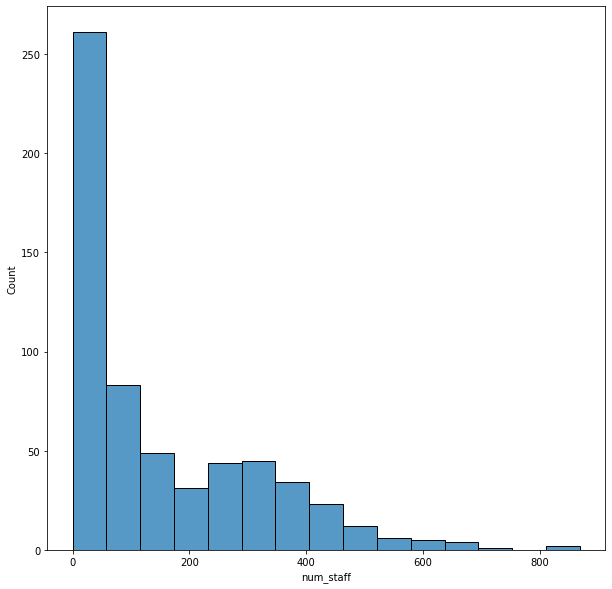

In [65]:
sns.histplot(x=train['num_staff'])

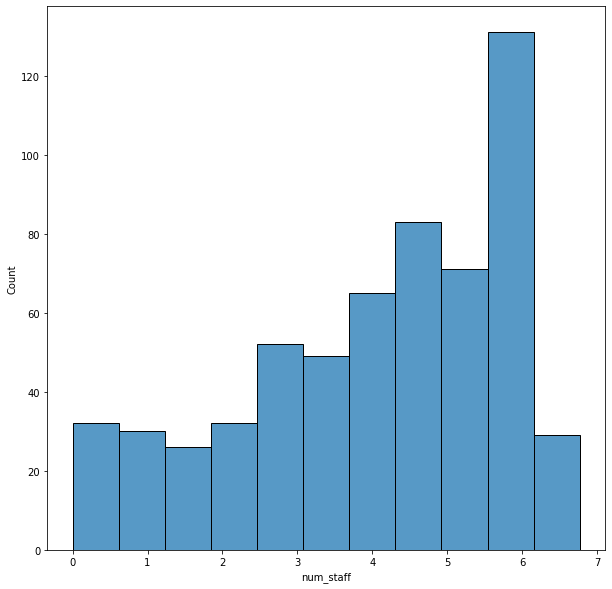

In [66]:
#위의 그래프가 왜곡되어있으므로 log1p 변환을 통해 왜곡 정도 향상
train['num_staff'] = np.log1p(train['num_staff'])
test['num_staff'] = np.log1p(test['num_staff'])
sns.histplot(x=train['num_staff'])

## 10. 주연배우 수 (num_actor)

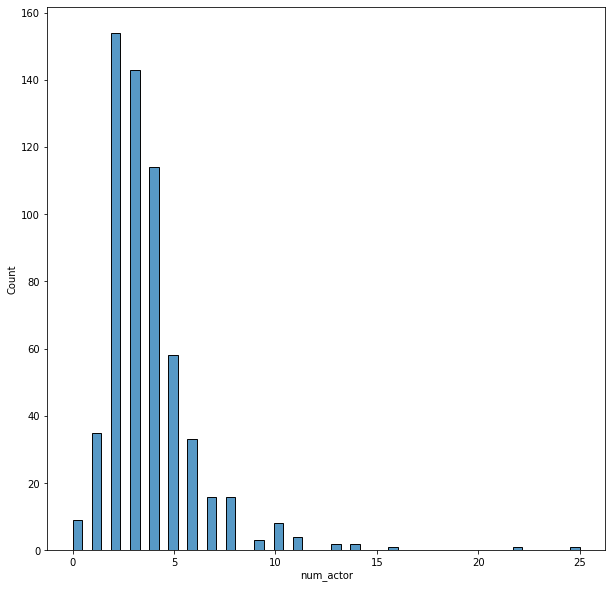

In [67]:
sns.histplot(x=train['num_actor'])

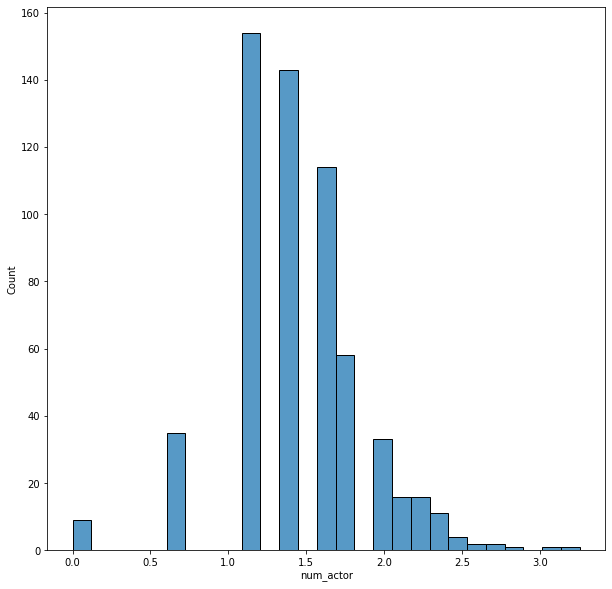

In [68]:
#위의 그래프가 왜곡되어있으므로 log1p 변환을 통해 왜곡 정도 향상
train['num_actor'] = np.log1p(train['num_actor'])
test['num_actor'] = np.log1p(test['num_actor'])
sns.histplot(x=train['num_actor'])

## 11. 상영등급 (screening_rat)

In [69]:
# 항목개수가  4개밖에 안되어서 원핫 인코딩
train=pd.get_dummies(train,columns=['screening_rat'])
test=pd.get_dummies(test,columns=['screening_rat'])
train.head()

,release_time,num_staff,num_actor,box_off_num,dist_rank,genre_rank,time_log,box_off_num_log,drp_rank2,dr_mean,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,2012-11-22,4.521789,1.098612,23398,134,11,4.574711,10.060449,1.0,5.030224,0,0,0,1
1,2011-11-24,5.537334,1.945910,1118258,134,11,4.718499,13.927284,1.0,6.963642,0,1,0,0
2,2011-08-10,6.533789,1.609438,7482180,134,11,4.812184,15.828035,2.0,15.187954,0,1,0,0
3,2015-09-24,5.963579,1.098612,609063,134,11,4.727388,13.319679,3.0,14.306743,1,0,0,0
4,2015-08-13,6.086775,1.386294,431310,134,11,4.804021,12.974585,4.0,12.338781,0,1,0,0


## 12. 관객 수 (box_off_num)

(array([514.,  45.,  15.,   9.,   3.,   4.,   4.,   1.,   3.,   2.]),
 array([1.00000000e+00, 1.42627750e+06, 2.85255400e+06, 4.27883050e+06,
        5.70510700e+06, 7.13138350e+06, 8.55766000e+06, 9.98393650e+06,
        1.14102130e+07, 1.28364895e+07, 1.42627660e+07]),
 <a list of 10 Patch objects>)

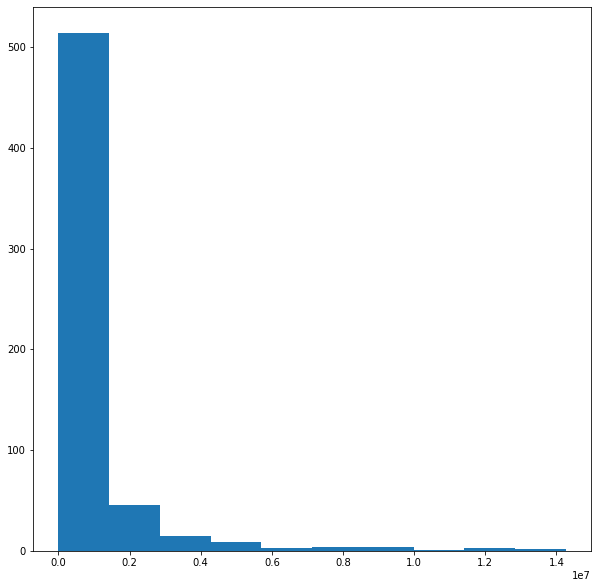

In [70]:
plt.hist(train['box_off_num'])

(array([  3.,   3.,  25., 105., 124.,  79.,  55.,  67.,  98.,  41.]),
 array([ 0.69314718,  2.27114876,  3.84915034,  5.42715192,  7.00515351,
         8.58315509, 10.16115667, 11.73915825, 13.31715983, 14.89516141,
        16.47316299]),
 <a list of 10 Patch objects>)

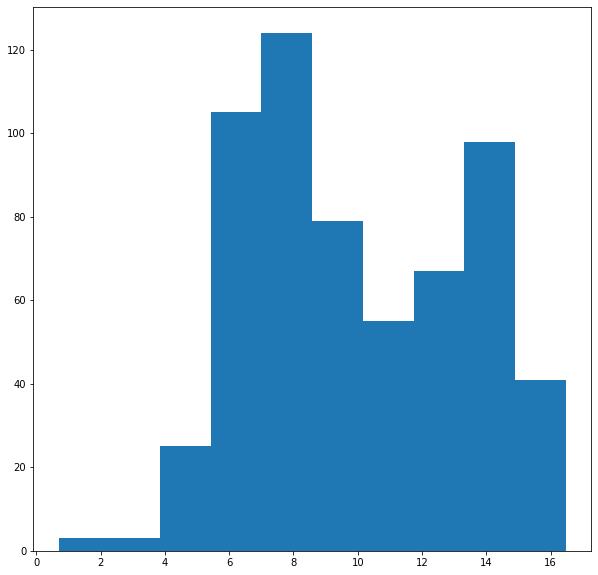

In [71]:
#위의 그래프가 왜곡되어있으므로 log1p 변환을 통해 왜곡 정도 향상
train['box_off_num']=np.log1p(train.box_off_num)
plt.hist(train['box_off_num'])

# **회귀 트리 모델 돌리기**

In [72]:
#모듈 임포트
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [73]:
#train 데이터 분할
X_features = train.drop(columns = 'box_off_num',axis=1)
y_labels = train['box_off_num']

X_train, X_tr_test, y_train, y_tr_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)
print(X_train.shape,X_tr_test.shape)

(480, 13) (120, 13)


In [78]:
test.shape

(243, 13)

# (5) LightGBM

In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   release_time            600 non-null    object 
 1   num_staff               600 non-null    float64
 2   num_actor               600 non-null    float64
 3   box_off_num             600 non-null    float64
 4   dist_rank               600 non-null    int64  
 5   genre_rank              600 non-null    int64  
 6   time_log                600 non-null    float64
 7   box_off_num_log         600 non-null    float64
 8   drp_rank2               600 non-null    float64
 9   dr_mean                 600 non-null    float64
 10  screening_rat_12세 관람가   600 non-null    uint8  
 11  screening_rat_15세 관람가   600 non-null    uint8  
 12  screening_rat_전체 관람가    600 non-null    uint8  
 13  screening_rat_청소년 관람불가  600 non-null    uint8  
dtypes: float64(7), int64(2), object(1), uint8(

In [74]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMRegressor 임포트
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [75]:
#lightgbm 하이퍼 파라미터 조정 전 
lgbm_reg1 = LGBMRegressor(n_estimators=1000)

evals = [(X_tr_test,y_tr_test)]
lgbm_reg1.fit(X_train, y_train,
                 early_stopping_rounds=100, eval_metric="logloss",
                 eval_set=evals, verbose=True)
preds1 = lgbm_reg1.predict(X_tr_test)

ValueError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#성능 평가 방법

#log 값 변환 시 NAN등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
  log_y=np.log1p(y)
  log_pred=np.log1p(pred)
  squared_error=(log_y-log_pred)**2
  rmsle=np.sqrt(np.mean(squared_error))
  return rmsle

#사이킷 런의 mean_sqaure_error()를 이용해 RMSE 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

#MSE,RMSE,RMSLE를 모두 계산
def evaluate_regr(y,pred):
  rmsle_val=rmsle(y,pred)
  rmse_val=rmse(y,pred)
  #MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val=mean_absolute_error(y,pred)
  print('RMSLE:{0:.3f},RMSE:{1:.3f},MAE:{2:.3f}'.format(rmsle_val,rmse_val,mae_val))

In [ ]:
#하이퍼 파라미터 조정 전 성능 평가결과
evaluate_regr(y_tr_test,preds1)

In [ ]:
##안쓸 듯,,
#모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model,X_train,X_tr_test,y_train,y_tr_test,is_expm1=False):
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_tr_test=np.expm1(y_tr_test)
    pred=np.expm1(pred)
  print('###',model.__class__.__name__,'###')
  evaluate_regr(y_tr_test,pred)

In [ ]:
#grid search CV
lgbm_reg2 = LGBMRegressor(n_estimators=1000)
from sklearn.model_selection import GridSearchCV

params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

lgbm_grid = GridSearchCV(lgb.LGBMRegressor(random_state=156), params,scoring='r2',cv=5)
lgbm_grid.fit(X_train, y_train)

lgbm_reg2 = lgb.LGBMRegressor(random_state=156)
lgbm_reg2.fit(X_train,y_train)

print('GridSearchCV 최적 estimator:', lgbm_grid.best_estimator_)
print('GridSearchCV 최적 파라미터:', lgbm_grid.best_params_)

In [ ]:
# 최적파라미터로 학습/예측/평가
lgbm_reg2 =  LGBMRegressor(n_estimators=1000, num_leaves=14 ,max_depth=-1,learning_rate=0.03)

evals = [(X_tr_test, y_tr_test)]
lgbm_reg2.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="logloss", eval_set=evals, verbose=True)

preds2 = lgbm_reg2.predict(X_tr_test)

In [ ]:
#하이퍼 파라미터 성능 평가 결과
evaluate_regr(y_tr_test,preds2)
#하이퍼 파라미터 전보다 더 안좋게 나옴.

In [ ]:
#피처 중요도
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_reg2,ax=ax)

**p353 이상치 제거하고나서 모델 돌리면 rmse 값 작아짐**
이상치 제거 -> 최적 alpha 값 다시 찾음

In [ ]:
y_train=pd.DataFrame(y_train)

In [ ]:
plt.scatter(x=X_train['dr_mean'], y=y_train['box_off_num'])
plt.ylabel('box_off_num', fontsize=15)
plt.xlabel('dr_mean', fontsize=15)
plt.show()
#이상치 없음

In [ ]:
plt.scatter(x=X_train['num_staff'], y=y_train['box_off_num'])
plt.ylabel('box_off_num', fontsize=15)
plt.xlabel('num_staff', fontsize=15)
plt.show()
#이상치 없음

In [ ]:
plt.scatter(x=X_train['time'], y=y_train['box_off_num'])
plt.ylabel('box_off_num', fontsize=15)
plt.xlabel('time', fontsize=15)
plt.show()
#40,160 이상치 있음. -> 제외

In [ ]:
test.shape